In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.xkcd()
# rcParams['font.family'] = ['xkcd', 'Comic Neue', 'Comic Mono']

import xarray as xr
import random 
import os 


from tempest2 import handler, casestudy, grid, joint_distrib, storm_tracker 
from tempest2.plots.hist import simple_hist

from work.plots.hist import simple_hist
from work.transect import add_transects_with_aligned_boxes,make_mask_box
from work.job_tools.funcs import merge_missing_vars

settings_path = 'settings/sam3d.yaml'

import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 4.03 seconds


In [2]:
def add_gridlines(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'gray'}
    gl.xlocator = plt.MaxNLocator(integer=True)
    gl.ylocator = plt.MaxNLocator(integer=True)

In [3]:
duration_min = 6 #10
surfmaxkm2_min = 10000 #50000 #20000 has 10k elements while 10000 has 29k 
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"updated_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)
ft = xr.open_dataset(storms_path)
storms = xr.open_dataset(st.file_storms)

def filter_storm(ft, region_lonmin, region_lonmax, region_latmin, region_latmax, vavg_min=None, vavg_max=None): #, start_date = 
    if vavg_max is None and vavg_min is None : 
        pass
    elif vavg_max is None :
        ft =  ft.where(ft.INT_velocityAvg > vavg_min, drop=True)
    elif vavg_min is None :
        ft = ft.where(ft.INT_velocityAvg < vavg_max, drop=True)
    elif vavg_min is not None and vavg_max is not None : 
        print("you don't understand what you're doing my dear")
    # Apply latitude and longitude constraints
    ft = ft.where((ft.INT_latmin >= region_latmin) & (ft.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        ft = ft.where((ft.INT_lonmin >= region_lonmin) & (ft.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        ft = ft.where((ft.INT_lonmin >= 360+region_lonmin) | (ft.INT_lonmin <= region_lonmax), drop=True)
    return ft


ft["INT_max_accumulated_90"] = np.max(ft.LC_accumulated_prec_90th, axis=1)
ft["INT_max_instant_99"] = np.max(ft.LC_instant_prec_99th, axis=1)
ft["INT_max_accumulated_95"] = np.max(ft.LC_accumulated_prec_95th, axis=1)
ft["INT_max_instant_95"] = np.max(ft.LC_instant_prec_95th, axis=1)
ft["INT_sum_total"] = np.sum(ft.LC_total_prec, axis=1)

# ft = ft.dropna(dim='DCS_number', subset=['INT_velocityAvg', 'INT_sum_total', 'INT_max_instant_99', 'INT_max_accumulated_90'])

ft =  ft.where((ft.INT_max_accumulated_95)+2*(ft.INT_max_instant_99)>100, drop=True)

## Dev metpy hmix and theta

In [4]:
import metpy.calc as mpcalc
from metpy.calc import virtual_potential_temperature, density
from metpy.units import units

def load_theta_v_and_pho(i_t, z_idx, sel_dict): 
    """
    z_idx = "all", "L'altitude de la troposphère" or int idx
    """
    PP = hdlr.load_var(cs, "PP", i_t, z_idx = z_idx, sel_dict = sel_dict).isel(time=0)
    TABS = hdlr.load_var(cs, "TABS", i_t, z_idx = z_idx, sel_dict = sel_dict).isel(time=0)
    QV = hdlr.load_var(cs, "QV", i_t, z_idx = z_idx, sel_dict = sel_dict).isel(time=0)

    pressure = (PP.PP + 100*PP.p) * units.Pa
    temperature = TABS.TABS*units.K 
    qv = QV.QV * units('g/kg') 
    theta_v = virtual_potential_temperature(pressure, temperature, qv)
    pho = density(pressure, temperature, qv)
    return theta_v, pho

def density_average(X, pho, z_sfc_idx, z_idx, z_all):
    arr_d_z = np.diff(z_all)
    arr_d_z_re = arr_d_z.reshape(arr_d_z.shape + (1,) * (X.ndim - 1))
    numerator = np.sum(
        X[z_sfc_idx:z_idx+1] * pho[z_sfc_idx:z_idx+1] * arr_d_z_re[z_sfc_idx:z_idx+1],
        axis=0
    )
    denominator = np.sum(
        pho[z_sfc_idx:z_idx+1] * arr_d_z_re[z_sfc_idx:z_idx+1],
        axis=0
    )
    return numerator / denominator

def height_mixed_layer(theta_v, pho, z_all):
    h_mix = np.full_like(theta_v[0], np.nan)
    h_mix_as_z_idx = np.full_like(theta_v[0], 0, dtype = int)
    for z_idx, z in enumerate(z_all[:15]):
        pho_avg_theta_v = density_average(theta_v, pho, 0, z_idx, z_all)
        mask = (theta_v[z_idx+1].values > pho_avg_theta_v.values + 0.2)
        nan_mask = np.isnan(h_mix)
        min_mask = (mask & nan_mask) #since z necessarily ascending
        h_mix[min_mask] = z
        h_mix_as_z_idx[min_mask] = z_idx
    return h_mix, h_mix_as_z_idx

def theta_v_mixed_layer(i_t, sel_dict):
    theta_v, pho = load_theta_v_and_pho(i_t, "La couche limite de mélange", sel_dict)
    theta_v_mix = np.full_like(theta_v[0], np.nan)
    z_all = theta_v.z.values.copy()
    h_mix, h_mix_as_z_idx = height_mixed_layer(theta_v, pho, z_all)
    shape = h_mix.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            z_idx = h_mix_as_z_idx[i, j]
            theta_v_mix[i, j] = density_average(
                theta_v[:, i, j], pho[:, i, j], 0, z_idx, z_all
            )
    return theta_v_mix

def wind_mixed_layer(i_t, sel_dict):
    U = hdlr.load_var(cs, "U", i_t, z_idx = "La couche limite de mélange", sel_dict = sel_dict).isel(time=0)
    V = hdlr.load_var(cs, "V", i_t, z_idx = "La couche limite de mélange", sel_dict = sel_dict).isel(time=0)

    u = U.u * units('m/s')
    v = V.v * units('m/s')

    theta_v, pho = load_theta_v_and_pho(i_t, "La couche limite de mélange", sel_dict)
    h_mix, h_mix_as_z_idx = height_mixed_layer(theta_v, pho)
    shape = h_mix.shape

    u_mix = np.full_like(theta_v[0], np.nan)
    v_mix = np.full_like(theta_v[0], np.nan)

    for i in range(shape[0]):
        for j in range(shape[1]):
            z_idx = h_mix_as_z_idx[i, j]
            u_mix[i, j] = density_average(
                u[:, i, j], pho[:, i, j], 0, z_idx
            )
            v_mix[i,j] = density_average(
                v[:, i, j], pho[:, i, j], 0, z_idx
            )
    return u_mix, v_mix

def compute_advection(u_mix, v_mix, theta_v_mix, lon, lat):
    """
    Chat output, didn't tested it yet, neither the wind_mixed_layer above
    
    Compute the advection term of theta_v_mix with respect to the wind fields u_mix and v_mix.
    
    Parameters:
    - u_mix: 2D numpy array of zonal wind components (east-west) over (lat, lon) grid
    - v_mix: 2D numpy array of meridional wind components (north-south) over (lat, lon) grid
    - theta_v_mix: 2D numpy array of scalar field over (lat, lon) grid
    - lon: 1D numpy array of longitude values (in degrees)
    - lat: 1D numpy array of latitude values (in degrees)

    Returns:
    - advection_term: 2D numpy array of the advection term over the grid
    """
    # Earth's radius in meters
    R = 6371000  
    
    # Convert latitude and longitude to radians
    lon_rad = np.deg2rad(lon)
    lat_rad = np.deg2rad(lat)
    
    # Compute grid spacing in radians
    dlon = np.gradient(lon_rad)
    dlat = np.gradient(lat_rad)
    
    # Create 2D arrays of longitude and latitude
    lon2d, lat2d = np.meshgrid(lon_rad, lat_rad)
    
    # Compute grid spacing in meters
    dx = R * np.cos(lat2d) * dlon[np.newaxis, :]  # Shape (lat, lon)
    dy = R * dlat[:, np.newaxis]  # Shape (lat, lon)
    
    # Compute gradients of theta_v_mix
    dtheta_dx = np.gradient(theta_v_mix, axis=1) / dx  # Gradient in x-direction
    dtheta_dy = np.gradient(theta_v_mix, axis=0) / dy  # Gradient in y-direction
    
    # Compute advection term
    advection_term = -(u_mix * dtheta_dx + v_mix * dtheta_dy)
    
    return advection_term

def height_surface_inversion(temperature, z_all):
    h_inv_sfc = np.full_like(temperature[0], np.nan)
    len_z = temperature.shape[0] ## assume z is first coordinate
    z_levels = z_all[:len_z+1] ## assume temperature z_field always starts from the ground 
    dz = np.diff(z_levels)[:, np.newaxis, np.newaxis]  # Shape: (z-1, 1, 1)
    dT_dz = np.diff(temperature, axis=0) / dz 

    for z_idx in range(dT_dz.shape[0]):
        mask = (dT_dz < 0)
        nan_mask = np.isnan(h_inv_sfc)
        min_mask = mask & nan_mask
        h_inv_sfc[min_mask] = z_levels[z_idx]

    return h_inv_sfc

## Anim plot below

In [15]:
test = hdlr.load_var(cs, "PP", 1008, z_idx="L'altitude de la troposphère", sel_dict={"lat" : slice(0,1), "lon" : slice(0,1)})
# test = test.where(test.p > 50, drop=True)
# z_targets = [300, 2000, 4000, 8000, 12000]
# z_indices = [np.abs(test.z.values - target).argmin() for target in z_targets]
z_all = test.z.values.copy()
# z_tropo = z_all[:np.abs(test.z.values - 15000).argmin()+1] # L'alitude de la Troposphère est à 15000m à l'équateur max non ? utiliser les pressions ? 
# print("z_shear index", z_indices)
# print("len z_tropo", len(z_tropo))

# p_targets = [1000, 950, 900, 850, 800, ...] #mbar or hPa
# p_targets = list(range(1000, 200, -40))  # From 1000 to 50 (exclusive), decreasing by 50

p_all = test.p.values.copy()
p_targets = [925, 850, 700, 500, 200] #mbar or hPa
p_indices = [np.abs(p_all-target).argmin() for target in p_targets] 

# p_indices = list(range(9, 20, 1)) + list(range(20, len(z_all), 5))
print("p indexex", p_indices)
test.close()

# Assuming z_indexes is a list or array of indices
# p_indices = p_all 

num_levels = len(p_indices)
colormap = plt.cm.rainbow_r
colors_w = [colormap(i / (num_levels - 1)) for i in range(num_levels)]

# Define the range and the scaling factor
start = 0.1  # Start value (must be > 0 for logspace)
end = 3       # End value
n_points = len(z_all)  # Number of points in the log space
w_linspace = np.linspace(start, end, len(p_all))

# Select thresholds using p_indices
w_thresholds = w_linspace[p_indices]

p indexex [12, 19, 27, 32, 45]


In [16]:
len(w_linspace)

52

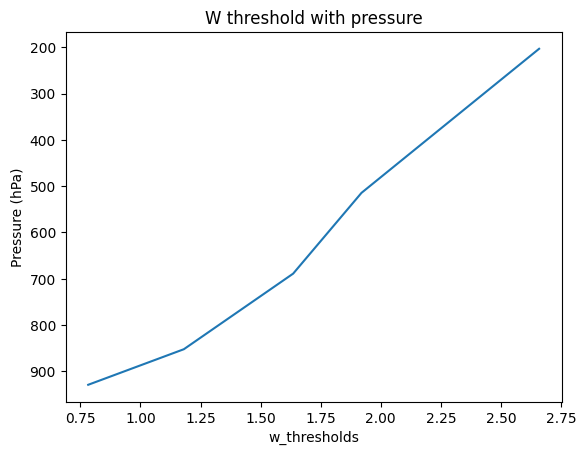

In [17]:
w_thresholds
plt.plot(w_thresholds, p_all[p_indices])
# plt.plot(w_linspace, p_all)
plt.gca().invert_yaxis()  # Inverts the y-axis so pressure decreases upward
plt.xlabel('w_thresholds')
plt.ylabel('Pressure (hPa)')
plt.title('W threshold with pressure')
plt.show()


In [18]:
print(p_all[p_indices])
w_thresholds

[929.173 852.338 688.965 514.475 203.111]


array([0.78235294, 1.18039216, 1.63529412, 1.91960784, 2.65882353])

I choose you ! :  260951
Processing frame 0
12 0.7823529411764706
19 1.1803921568627451
27 1.6352941176470588
32 1.919607843137255
45 2.6588235294117646


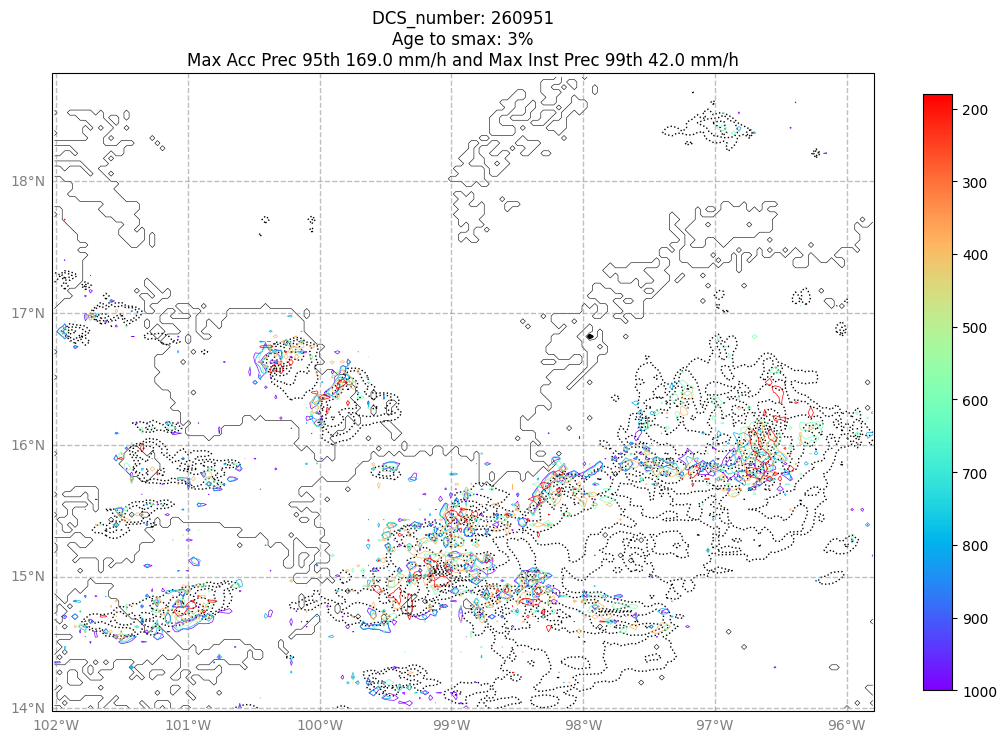

Processing frame 1
12 0.7823529411764706
19 1.1803921568627451
27 1.6352941176470588
32 1.919607843137255
45 2.6588235294117646


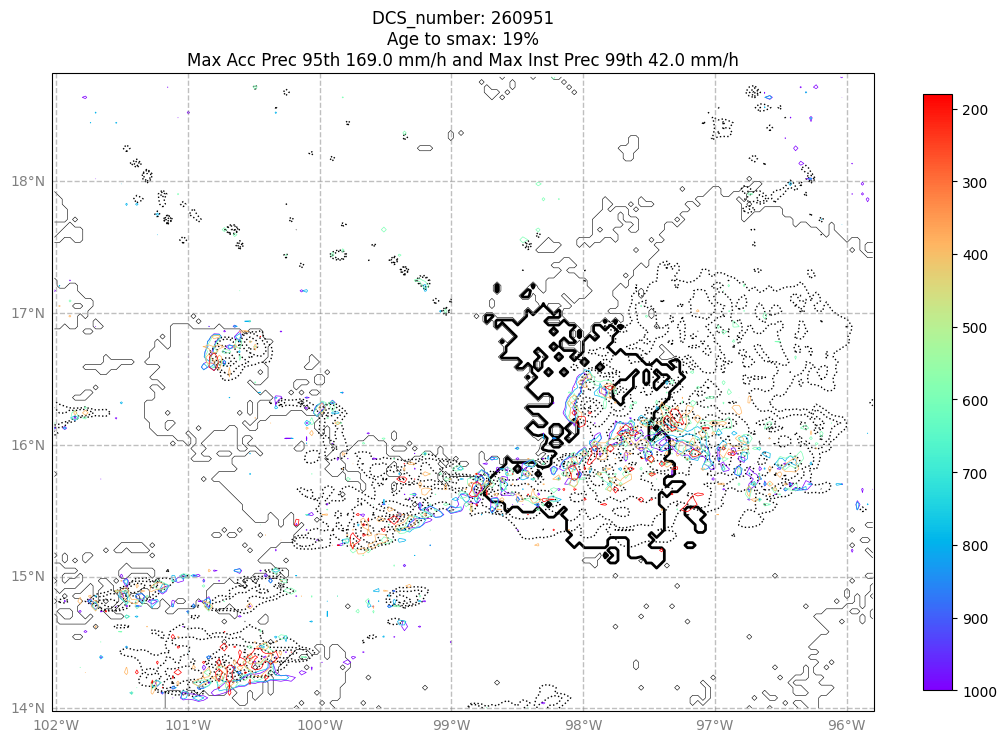

Processing frame 2
12 0.7823529411764706
19 1.1803921568627451
27 1.6352941176470588
32 1.919607843137255
45 2.6588235294117646


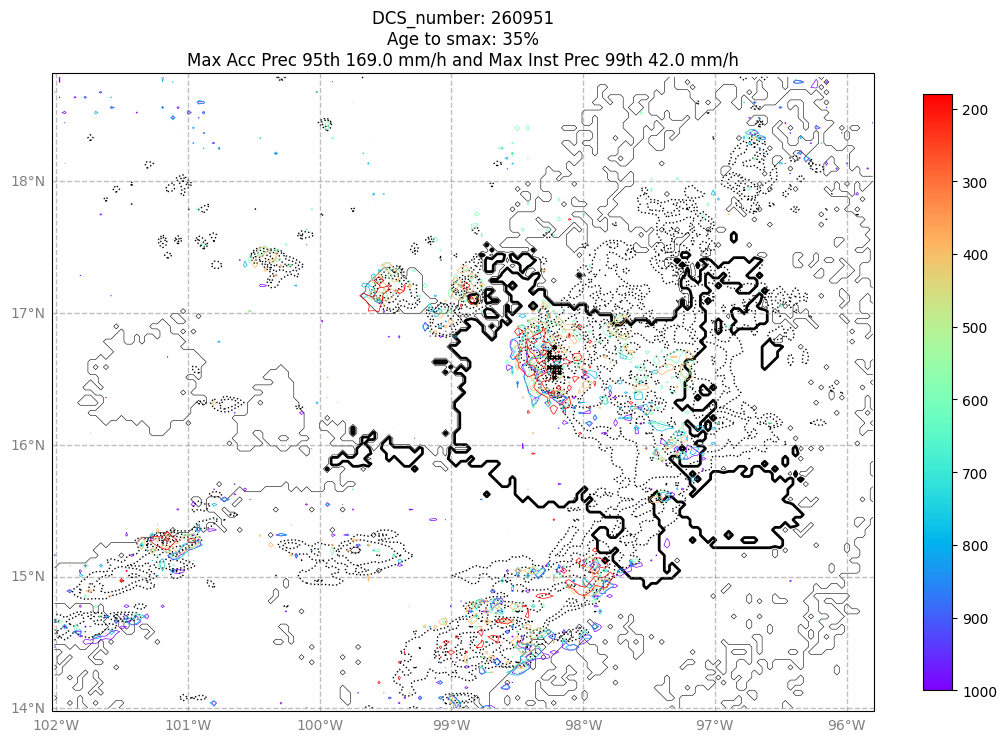

Processing frame 3
12 0.7823529411764706
19 1.1803921568627451
27 1.6352941176470588
32 1.919607843137255
45 2.6588235294117646


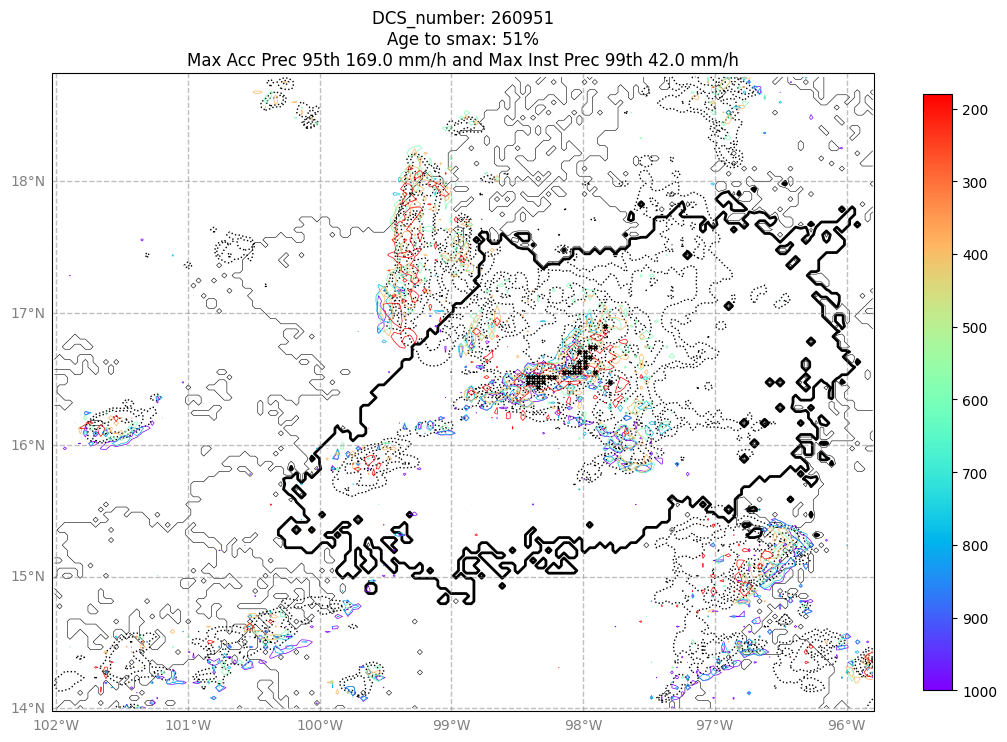

Processing frame 4
12 0.7823529411764706
19 1.1803921568627451
27 1.6352941176470588
32 1.919607843137255
45 2.6588235294117646


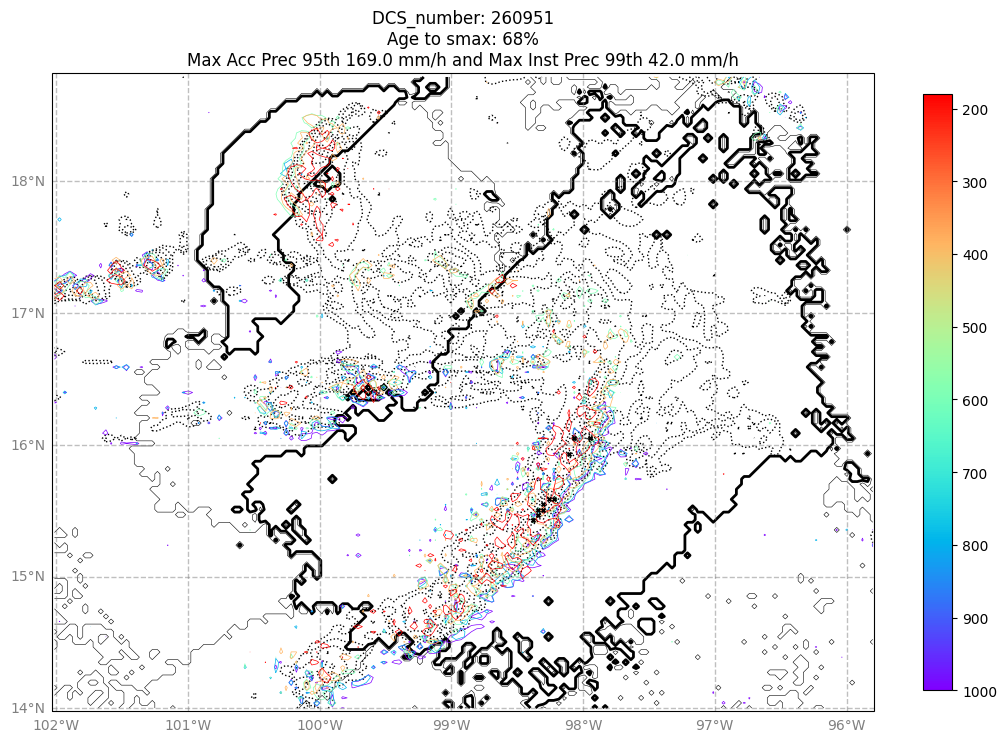

Processing frame 5
12 0.7823529411764706
19 1.1803921568627451
27 1.6352941176470588
32 1.919607843137255
45 2.6588235294117646


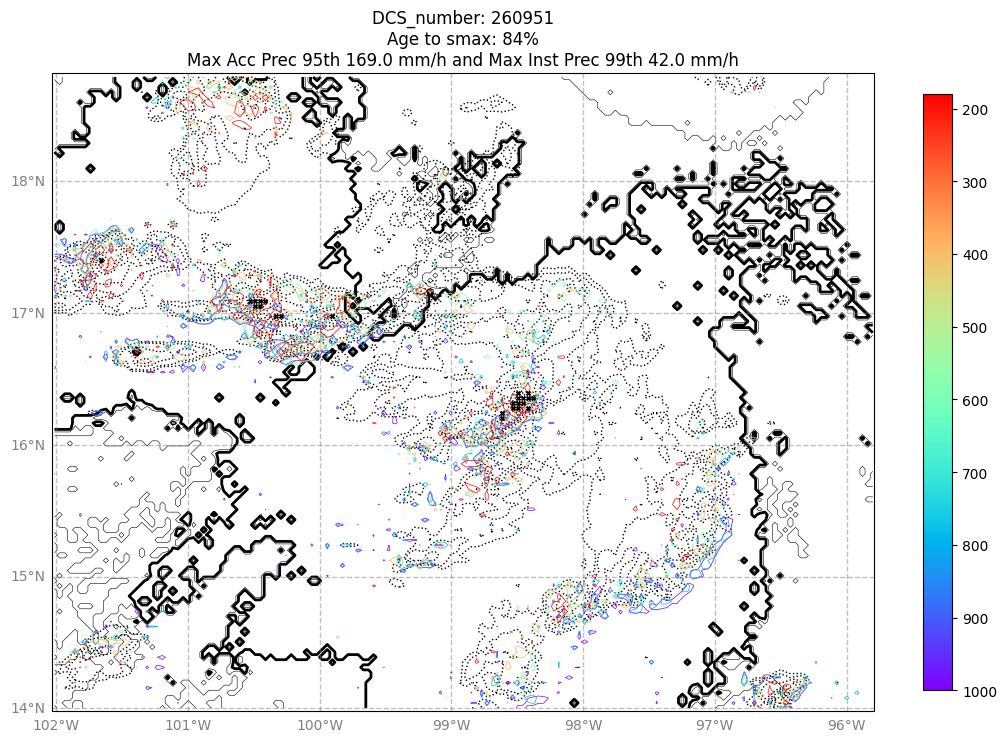

Processing frame 6
12 0.7823529411764706
19 1.1803921568627451
27 1.6352941176470588
32 1.919607843137255
45 2.6588235294117646


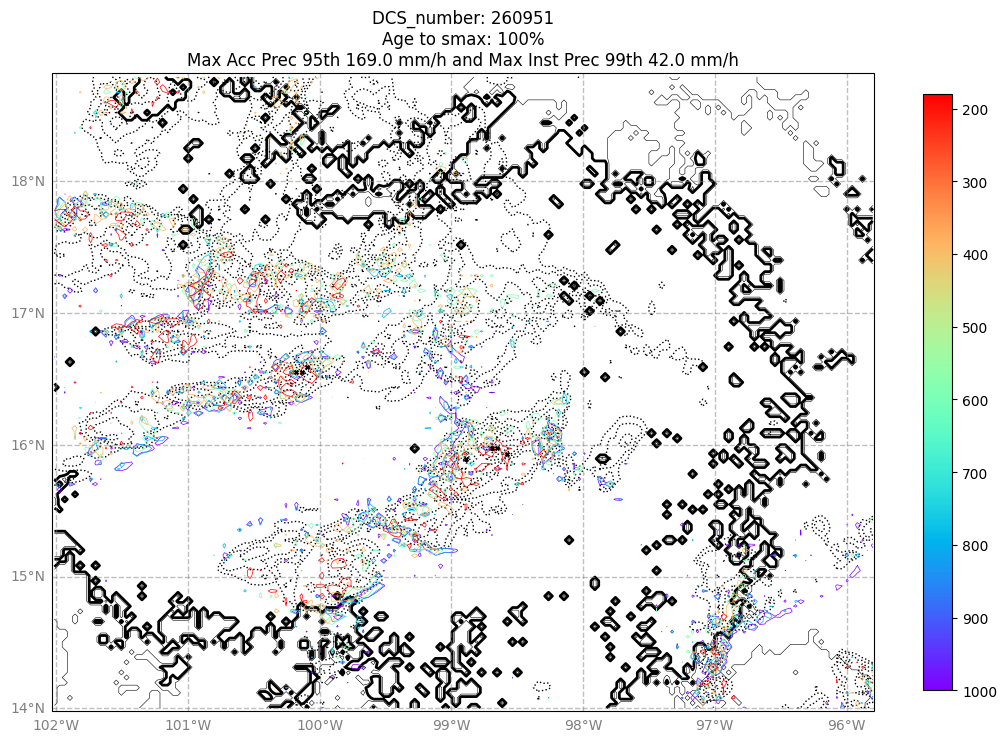

Skip frame 7
Skip frame 8
Skip frame 9
Skip frame 10
Skip frame 11


In [19]:
import warnings
import matplotlib.colors as mcolors
import matplotlib
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

times_3d = [0]
while len(times_3d)<3:
    iDCS = random.choice(ft.DCS_number.values)
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d = st.get_frame_data(ft, iDCS)

iDCS = 260951
start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d = st.get_frame_data(ft, iDCS)

print("I choose you ! : ", iDCS)

large_scale_frame_size = 2
full_extent, full_slice_lon, full_slice_lat = st.get_full_extent_slice(lons[:i_smax+1], lats[:i_smax+1], large_scale_frame_size=large_scale_frame_size)

slice_lat, slice_lon, extent = full_slice_lat, full_slice_lon, full_extent
projection = ccrs.PlateCarree(central_longitude=0)
figsize_ratio = 4 / large_scale_frame_size

# Dictionaries for selection
le_dico_long = {"latitude": slice_lat, "longitude": slice_lon}
le_dico_court = {"lat": slice_lat, "lon": slice_lon}

time_current = times_3d[0]
seg = hdlr.load_seg(time_current, sel_dict=le_dico_long)[0]
lat = seg['latitude'].values
lon = seg['longitude'].values
lon_grid, lat_grid = np.meshgrid(lon, lat)

prec_levels = [1, 3, 10, 20, 30, 40, 50]

# Create directory for outputs
output_dir = f"/scratchx/mcarenso/shear/3d_analysis/DCS_{iDCS}/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

theta_v_mix_cmap = plt.get_cmap('RdBu_r')
theta_v_mix_norm = mcolors.Normalize(vmin=298, vmax=303)


for i, time_current in enumerate(times_3d):    
    # Create a new figure and axis each iteration
    fig, ax = plt.subplots(
        figsize=(figsize_ratio * (extent[1] - extent[0]), figsize_ratio * (extent[3] - extent[2])),
        subplot_kw={"projection": projection}
    )
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    add_gridlines(ax)
    
    seg = hdlr.load_seg(time_current, sel_dict=le_dico_long)[0]
    prec = hdlr.load_var(cs, "Prec", time_current, sel_dict=le_dico_court)
    
    # Output DCS mask
    output = np.full_like(seg, 0.5, dtype=float)
    output[np.isnan(seg)] = 0
    output[seg == iDCS] = 1

    age_to_smax = int(100 * np.round((time_current - st.settings["TIME_RANGE"][0] - start) / (time_smax - start), 2))

    if np.max(output)<1 or age_to_smax>100:
        print(f"Skip frame {i}")
        plt.close(fig)
        pass
    else :
        print(f"Processing frame {i}")

        # theta_v_mix = theta_v_mixed_layer(time_current, le_dico_court)
        # im_theta_v = ax.pcolormesh(lon_grid, lat_grid, theta_v_mix, cmap=theta_v_mix_cmap, norm = theta_v_mix_norm, alpha=1.0)

        # Contours for DCS
        ax.contour(lon_grid, lat_grid, output, levels=[0.75], colors='black', linewidths=[2.0], linestyles='solid')
        ax.contour(lon_grid, lat_grid, output, levels=[0.25], colors='black', linewidths=[0.4], linestyles='solid')

        contour_prec = ax.contour(lon_grid, lat_grid, prec.values, levels=prec_levels, colors='black', linewidths=1, linestyles='dotted')

        max_prec_inst_99 = np.round(ft.sel(DCS_number=iDCS).INT_max_instant_99).values
        my_DCS = (output == 1)

        # Mask precipitation below threshold and outside DCS
        xprec = np.ma.masked_less_equal(prec, max_prec_inst_99)
        xprec.mask[~my_DCS] = True
        extreme_prec_indices = np.where(~xprec.mask)
        if extreme_prec_indices[0].size > 0:
            extreme_lon = lon_grid[extreme_prec_indices]
            extreme_lat = lat_grid[extreme_prec_indices]
            # Plot crosses on top
            ax.scatter(extreme_lon, extreme_lat, c='k', marker='x', s=8, zorder=10, alpha = 1)

        # Plot W contours
        w = hdlr.load_var(cs, "W", time_current, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).W[0]
        for idx, i_z_plot in enumerate(p_indices):
            color = colors_w[::-1][idx]
            
            # Select 2D data for the current level
            w_level = w[i_z_plot, :, :]
            w_threshold = w_thresholds[idx]
            print(i_z_plot, w_threshold)
            # Plot the contour
            cs_w = ax.contour(
                lon_grid, 
                lat_grid, 
                w_level,  # Pass the 2D slice
                levels=[w_threshold],  # w_threshold, 1
                colors=[color], 
                linewidths=0.5,            
                )
        
        # Update title
        age_to_smax = int(100 * np.round((time_current - st.settings["TIME_RANGE"][0] - start) / (time_smax - start), 2))
        max_prec_acc_95 = np.round(ft.sel(DCS_number=iDCS).INT_max_accumulated_95).values
        max_prec_inst_99 = np.round(ft.sel(DCS_number=iDCS).INT_max_instant_99).values
        ax.set_title(
            f"DCS_number: {iDCS}\nAge to smax: {age_to_smax}%\n"
            f"Max Acc Prec 95th {max_prec_acc_95} mm/h and Max Inst Prec 99th {max_prec_inst_99} mm/h"
        )

        # Create the ScalarMappable as before, but ensure vmin < vmax
        sm = plt.cm.ScalarMappable(
            cmap=colormap,
            norm=plt.Normalize(vmin=1000, vmax=200)
        )
        sm.set_array([])

        # Create the colorbar once
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction = 0.1, shrink = 0.8)
        cbar.ax.invert_yaxis()  # Invert the colorbar visually

        fig.savefig(f"{output_dir}/frame_{i}.png")
        plt.show()

        plt.close(fig)

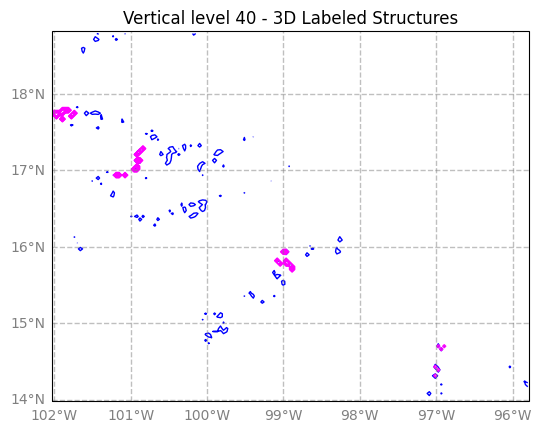

In [35]:
coherent_mask_3d = np.zeros_like(w, dtype=bool)
for i_z, thresh in enumerate(w_linspace):
    coherent_mask_3d[i_z, :, :] = w[i_z, :, :] > thresh

from skimage.measure import label
labels_3d = label(coherent_mask_3d, connectivity=3)


for structure_id in range(1, labels_3d.max() + 1):
    # Extract the indices of this structure
    z_coords, y_coords, x_coords = np.where(labels_3d == structure_id)
    
    # Check vertical extent
    vertical_extent = z_coords.max() - z_coords.min() + 1
    if vertical_extent < 51:
        # Remove this structure if it doesn't meet the criterion
        labels_3d[z_coords, y_coords, x_coords] = 0

i_z_plot = 40  # Some vertical level
fig, ax = plt.subplots(subplot_kw={"projection": projection})
ax.set_extent(extent, crs=ccrs.PlateCarree())
add_gridlines(ax)

# Plot your w field contours as before
w_level = w[i_z_plot, :, :]
ax.contour(lon_grid, lat_grid, w_level, levels=[w_linspace[i_z_plot]], colors='blue', linewidths=1.0)

# Plot the labeled structures as contours
# Since labels_3d is integral, you can contour at half-levels to show boundaries:
ax.contour(lon_grid, lat_grid, labels_3d[i_z_plot, :, :], 
           levels=np.arange(0.5, labels_3d.max()+1), 
           colors='magenta', linewidths=1.0)

plt.title(f"Vertical level {i_z_plot} - 3D Labeled Structures")
plt.show()


0.001814525500253225
3
104.872


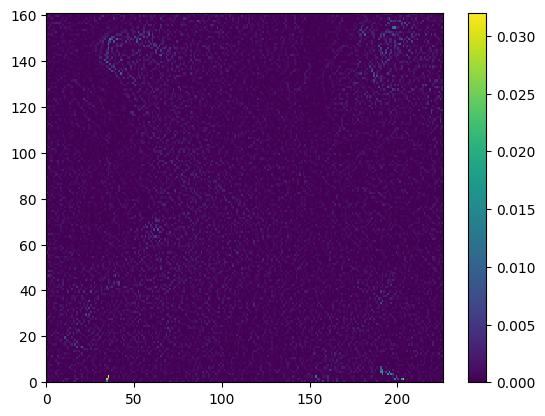

In [ ]:
# w.z
# i = 2
# print(w_thresholds[i])
# print(p_indices[i])
# plt.pcolormesh(w[i], vmin = 0)
# print(w.z[i].values)
# plt.colorbar()


In [143]:
print(z_all[p_indices])
print(p_all[p_indices])
colors_w[0]


[  104.872   563.049   978.97   1435.146  1910.179  2563.87   3175.719
  3552.077  4466.392  4966.392  5466.392  6466.392  7466.392  8466.392
  9466.392 10466.39  11966.39  13966.39  14966.39 ]
[998.952 946.148 900.329 852.338 804.78  743.078 688.965 657.333 585.465
 549.021 514.475 450.706 393.484 342.208 296.37  255.568 203.111 147.772
 125.471]


(0.5, 0.0, 1.0, 1.0)